<a href="https://colab.research.google.com/github/CaVoi52Hz/NLP/blob/main/22010846_LeThiThuy_Topic4_Final_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Final NLP (Natural Language Processing)**
##***Topic: Detecting Stress and Anxiety Indicators Using Deep Learning-Based Mental Health Text Classification***

**Full Name:** ***Le Thi Thuy***

**Student ID: *22010846***

**SCHOOL OF ELECTRICAL AND ELECTRONIC ENGINEERING - PHENIKAA UNIVERSITY**

***NATURAL LANGUAGE PROCESSING COURSE***

*Robotics and Artificial Intelligence Engineering Class*

*Cohort: 16*

*Email: 22010846@st.phenikaa-uni.edu.vn*




#**Part 1: Installing Libraries and Splitting the Dataset**
## **1.1. Installing the Necessary Libraries**


#**Phần 1: Cài Đặt Thư Viện Và Chia Tập Dữ Liệu**
## **1.1. Cài đặt các thư viện cần thiết**

In [ ]:
# Cài đặt thư viện xử lý tiếng Việt và mô hình Transformer
!pip install pyvi underthesea transformers datasets
!pip install -U accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.6 MB/s eta 0:00:00


## **1.2. Data Preprocessing and Statistics**

##**1.2. Tiền xử lý và Thống kê dữ liệu**

In [ ]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize

df = pd.read_csv('DataFinalNLP.csv', encoding='utf-8')

print(df.head())

# 2. Hàm làm sạch văn bản chuyên sâu
def clean_text(text):
    text = str(text).lower()
    # Xóa các ký tự đặc biệt, chỉ giữ lại chữ cái và số
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenize(text, format="text")
    return text

df['cleaned_text'] = df['Text_clear'].apply(clean_text)

# 3. Thống kê tập dữ liệu
print("\nDATASET STATISTICS")
print(f"Total samples: {len(df)}")
print("\nSamples per class:")
print(df['Final_Label'].value_counts())

df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
print(f"\nAverage text length: {df['word_count'].mean():.2f} words")
print(f"Median text length: {df['word_count'].median()} words")

# Kiểm tra tỷ lệ mất cân bằng lớp
imbalance_ratio = df['Final_Label'].value_counts(normalize=True) * 100
print("\nClass distribution (%):")
print(imbalance_ratio)

                                    Text_Ori  \
0                          mẹ ơi con mệt quá   
1                      ôm con được khong..."   
2  Chỉ có thể là dựa dẫm vào bản thân mình 😌   
3             có aii muốn làm bạn với mik k😊   
4                t chịu thuaa với đời ờiiii🥰   

                                 Text_clear  Label  Label_2 Check  Final_Label  
0                         mẹ ơi con mệt quá      0      0.0  Khớp            0  
1                         ôm con được không      1      1.0  Khớp            1  
2  Chỉ có thể là dựa dẫm vào bản thân mình       2      2.0  Khớp            2  
3         có ai muốn làm bạn với mình không      2      2.0  Khớp            2  
4                  tôi chịu thua với đời ơi      1      1.0  Khớp            1  

DATASET STATISTICS
Total samples: 1940

Samples per class:
Final_Label
2    716
1    653
0    571
Name: count, dtype: int64

Average text length: 13.98 words
Median text length: 10.5 words

Class distribution (%):
Final_Labe

##**1.3. Split the dataset (80/10/10)**

##**1.3. Chia tập dữ liệu (80/10/10)**

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text_clear'],
    df['Final_Label'],
    test_size=0.2,
    stratify=df['Final_Label'],
    random_state=42
)

# Chia 20% còn lại thành Val (10%) và Test (10%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_texts)} (80%)")
print(f"Val samples:   {len(val_texts)} (10%)")
print(f"Test samples:  {len(test_texts)} (10%)")

Total samples: 1940
Train samples: 1552 (80%)
Val samples:   194 (10%)
Test samples:  194 (10%)


#**Part 2: Architectural Design, Modeling, and Testing**

##**2.1: KimCNN Architectural Design**

This architecture consists of three main blocks:

+ Block 1: Embedding Layer: Transforms each word into a 100-dimensional vector so that the machine can understand its semantics.

+ Block 2: Multi-filter Convolutional Layer: Designed three filter sizes: 3, 4, and 5. Filter 3 will capture phrases like "very tired," and filter 5 will capture longer phrases like "don't want to do anything."

+ Block 3: Max-over-time Pooling: Only retains the strongest features from the filters to include in the final classification layer.

#**Phần 2: Thiết Kế Kiến Trúc Mô Hình Và Kiểm Thử**

##**2.1: Thiết kế kiến trúc KimCNN**

Kiến trúc này gồm 3 khối chính:

+ Khối 1: Embedding Layer: Biến mỗi từ thành một vector 100 chiều để máy hiểu được ngữ nghĩa.

+ Khối 2: Multi-filter Convolutional Layer: Thiết kế 3 kích thước filter là 3, 4, 5. Filter 3 sẽ bắt các cụm như "rất mệt mỏi", filter 5 sẽ bắt các cụm dài hơn như "không muốn làm gì cả".

+ Khối 3: Max-over-time Pooling: Chỉ giữ lại đặc trưng mạnh nhất từ các filter để đưa vào lớp phân loại cuối cùng.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KimCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        # Lớp nhúng: Biến từ thành vector 100 chiều
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters,
                      kernel_size=(fs, embed_dim))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch_size, sent_len]
        embedded = self.embedding(text).unsqueeze(1)

        # Qua Conv và ReLU (hàm kích hoạt)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        # Max-pooling: Lấy đặc trưng nổi bật nhất
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        # Kết hợp các đặc trưng lại và qua Dropout
        cat = self.dropout(torch.cat(pooled, dim=1))

        return self.fc(cat)

Initialize the model with parameters (Hyperparameters).

Khởi tạo mô hình với các tham số (Hyperparameters)

In [ ]:
# Thông số mô hình
VOCAB_SIZE = 5000
EMBED_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

model = KimCNN(VOCAB_SIZE, EMBED_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# Tính trọng số dựa trên bảng thống kê 1940 mẫu
# Nhãn 0: 571, Nhãn 1: 653, Nhãn 2: 716
weights = torch.tensor([1940/571, 1940/653, 1940/716], dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**2.1.1 Training loop**

In [ ]:
from collections import Counter

def build_vocab(texts, max_vocab_size=5000):
    all_words = []
    for text in texts:
        all_words.extend(str(text).split())

    counts = Counter(all_words)
    # Gán chỉ số: 0 cho PAD, 1 cho UNK, còn lại bắt đầu từ 2
    vocab = {word: i+2 for i, (word, _) in enumerate(counts.most_common(max_vocab_size))}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

# 2. Khởi tạo biến vocab
vocab = build_vocab(train_texts)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 2736


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset

# 1. Chuyển văn bản thành số và Padding
def encode_text(text, vocab, max_len=64):
    tokenized = str(text).split()
    encoded = [vocab.get(word, 1) for word in tokenized] # 1 là <UNK>
    if len(encoded) < max_len:
        encoded += [0] * (max_len - len(encoded)) # 0 là <PAD>
    return encoded[:max_len]

class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = [torch.tensor(encode_text(t, vocab)) for t in texts]
        self.labels = torch.tensor(labels.values)

    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

# 2. Khởi tạo Loader thực tế
train_dataset = MentalHealthDataset(train_texts, train_labels, vocab)
val_dataset = MentalHealthDataset(val_texts, val_labels, vocab)
test_dataset = MentalHealthDataset(test_texts, test_labels, vocab)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"DataLoader has been created {len(train_dataset)} Train exercise template!")

DataLoader has been created 1552 Train exercise template!


In [ ]:
import time
from sklearn.metrics import accuracy_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

history_loss = []
history_f1 = []

def calculate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in loader:
            texts = texts.to(device)
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return acc, f1

EPOCHS = 20
print(f"Start training KimCNN on {device}...")

for epoch in range(EPOCHS):
    start_time = time.time()

    # Giai đoạn Train
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Giai đoạn Evaluate (Đánh giá trên tập Validation)
    val_acc, val_f1 = calculate_metrics(model, val_loader)

    history_loss.append(total_loss/len(train_loader))
    history_f1.append(val_f1)

    end_time = time.time()

    # In kết quả
    print(f'Epoch: {epoch+1:02} | Loss: {total_loss/len(train_loader):.4f} | '
          f'Val Acc: {val_acc*100:.2f}% | Val F1: {val_f1:.4f} | '
          f'Time: {int(end_time - start_time)}s')



Start training KimCNN on cuda...
Epoch: 01 | Loss: 1.0963 | Val Acc: 56.19% | Val F1: 0.5570 | Time: 3s
Epoch: 02 | Loss: 0.7483 | Val Acc: 65.46% | Val F1: 0.6390 | Time: 1s
Epoch: 03 | Loss: 0.5609 | Val Acc: 57.73% | Val F1: 0.5691 | Time: 1s
Epoch: 04 | Loss: 0.4306 | Val Acc: 63.92% | Val F1: 0.6353 | Time: 1s
Epoch: 05 | Loss: 0.3342 | Val Acc: 67.01% | Val F1: 0.6703 | Time: 1s
Epoch: 06 | Loss: 0.2728 | Val Acc: 65.98% | Val F1: 0.6498 | Time: 1s
Epoch: 07 | Loss: 0.2044 | Val Acc: 64.43% | Val F1: 0.6357 | Time: 1s
Epoch: 08 | Loss: 0.1903 | Val Acc: 65.46% | Val F1: 0.6576 | Time: 1s
Epoch: 09 | Loss: 0.1388 | Val Acc: 64.95% | Val F1: 0.6486 | Time: 1s
Epoch: 10 | Loss: 0.1149 | Val Acc: 65.98% | Val F1: 0.6455 | Time: 1s
Epoch: 11 | Loss: 0.1184 | Val Acc: 64.43% | Val F1: 0.6401 | Time: 1s
Epoch: 12 | Loss: 0.0837 | Val Acc: 67.01% | Val F1: 0.6721 | Time: 1s
Epoch: 13 | Loss: 0.0875 | Val Acc: 67.53% | Val F1: 0.6710 | Time: 1s
Epoch: 14 | Loss: 0.0724 | Val Acc: 65.46% |

**2.1.2. Draw a graph of learning progress.**

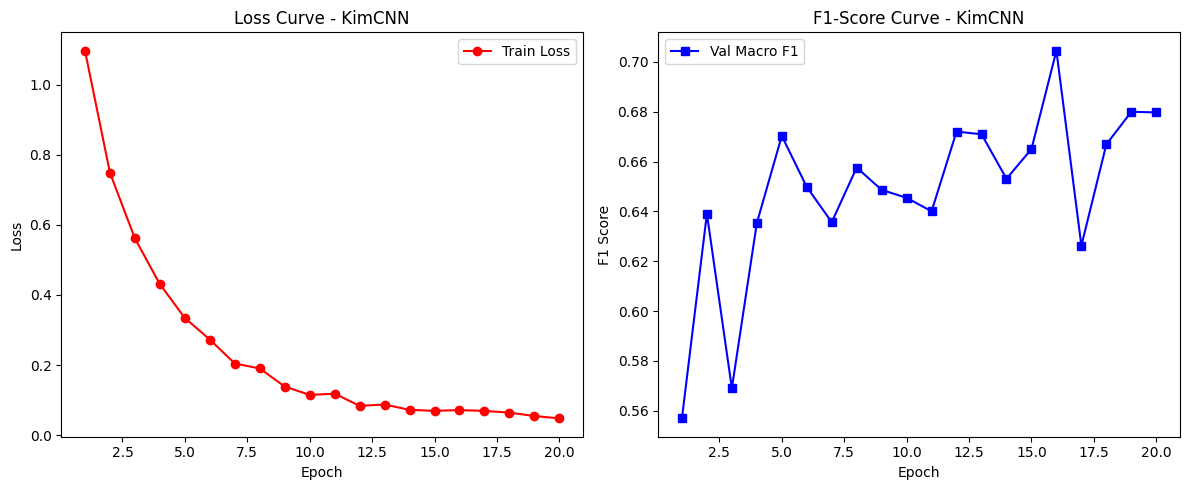

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Vẽ đồ thị Loss (Tự động lấy dữ liệu từ lần chạy vừa xong)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history_loss)+1), history_loss, 'r-o', label='Train Loss')
plt.title('Loss Curve - KimCNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ đồ thị F1-Score
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history_f1)+1), history_f1, 'b-s', label='Val Macro F1')
plt.title('F1-Score Curve - KimCNN')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

**2.1.3. Confusion Matrix**

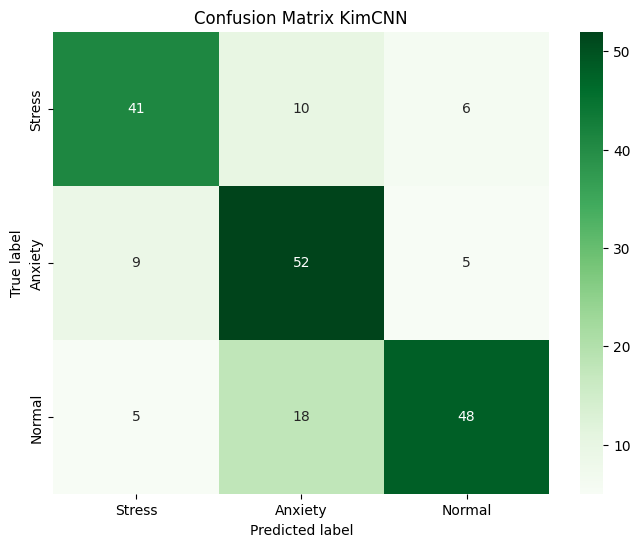

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lấy dự đoán từ tập Test
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model(texts)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix KimCNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**2.1.4. Generate detailed reports by class.**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import time

model.eval()
y_pred_1, y_true_1 = [], []

start_inf = time.time()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model(texts)
        y_pred_1.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_1.extend(labels.numpy())
end_inf = time.time()

# Tính toán các chỉ số
inf_time_1 = (end_inf - start_inf) / len(test_loader.dataset)
acc_1 = accuracy_score(y_true_1, y_pred_1)
macro_f1_1 = f1_score(y_true_1, y_pred_1, average='macro')
weighted_f1_1 = f1_score(y_true_1, y_pred_1, average='weighted')

print(f"MODEL 1 STATISTICS: KIMCNN")
print(f"1. Accuracy: {acc_1*100:.2f}%")
print(f"2. Macro-F1: {macro_f1_1:.4f}")
print(f"3. Weighted-F1: {weighted_f1_1:.4f}")
print(f"4. Avg Inference Time: {inf_time_1*1000:.4f} ms/sample")
print(f"\n5. Per-class Detail")
print(classification_report(y_true_1, y_pred_1, target_names=['Stress', 'Anxiety', 'Normal']))

MODEL 1 STATISTICS: KIMCNN
1. Accuracy: 72.68%
2. Macro-F1: 0.7276
3. Weighted-F1: 0.7277
4. Avg Inference Time: 0.0701 ms/sample

5. Per-class Detail
              precision    recall  f1-score   support

      Stress       0.75      0.72      0.73        57
     Anxiety       0.65      0.79      0.71        66
      Normal       0.81      0.68      0.74        71

    accuracy                           0.73       194
   macro avg       0.74      0.73      0.73       194
weighted avg       0.74      0.73      0.73       194



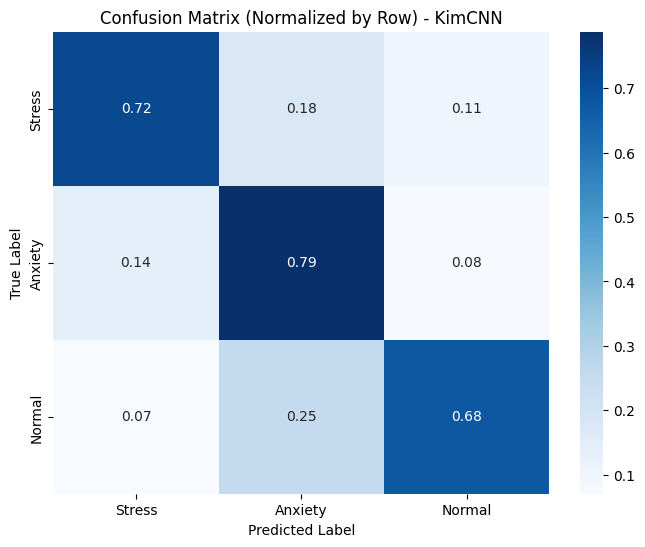

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
# Chuẩn hóa theo hàng (chia cho tổng mỗi hàng)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix (Normalized by Row) - KimCNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**2.1.5. Evaluating the model test**

In [ ]:
import random

def test_random_samples(model, vocab, test_texts, test_labels, num_samples=5):
    model.eval()
    classes = ['Stress', 'Anxiety', 'Normal']

    # Tạo danh sách các chỉ số ngẫu nhiên từ tập Test
    random_indices = random.sample(range(len(test_texts)), num_samples)

    print(f" EVALUATING {num_samples} RANDOM SAMPLES FROM TEST SET ")

    for i, idx in enumerate(random_indices):
        text = test_texts.iloc[idx]
        true_label = test_labels.iloc[idx]

        # Tiền xử lý và dự đoán
        tokens = encode_text(text, vocab)
        tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

        print(f"\n[{i+1}] Index: {idx} | Text: {text}")
        print(f"   Predicted: {classes[pred_label]} ({probs[0][pred_label].item()*100:.2f}%) | Actual: {classes[true_label]}")

        # Đánh giá nhanh đúng/sai
        status = "CORRECT" if pred_label == true_label else "INCORRECT"
        print(f"   Result: {status}")

# Chạy thử nghiệm ngẫu nhiên
test_random_samples(model, vocab, test_texts, test_labels, num_samples=5)

 EVALUATING 5 RANDOM SAMPLES FROM TEST SET 

[1] Index: 179 | Text: Tôi cảm thấy sự mệt mỏi tích tụ từng ngày mà không được giải tỏa
   Predicted: Stress (99.97%) | Actual: Stress
   Result: CORRECT

[2] Index: 187 | Text: cố lên thôi rồi sẽ qua mà 
   Predicted: Normal (72.98%) | Actual: Normal
   Result: CORRECT

[3] Index: 158 | Text: mình làm bất cứ chuyện gì cũng thất bại, đến nỗi mẹ và tất cả những người thân quen còn nói rằng mình sinh ra là sai lầm
   Predicted: Anxiety (47.38%) | Actual: Stress
   Result: INCORRECT

[4] Index: 148 | Text: um ước mơ thì lớn kinh tế còn khó khăn , mẹ thì làm việc không nổi nữa
   Predicted: Anxiety (73.97%) | Actual: Anxiety
   Result: CORRECT

[5] Index: 183 | Text: Tôi không có chú mà có thằng bạn già y vậy. Mỗi lần nói đi ăn là nó chuyển khoản trước hỏi sao nó bảo chị già nuôi con 3 đứa cực lắm còn anh già nuôi 1 mình anh già thôi ai nở để chị già trả tiền
   Predicted: Normal (64.32%) | Actual: Normal
   Result: CORRECT


##**2.2. BiLSTM + Attention Architectural Design**

##**2.2. Thiết kế kiến trúc BiLSTM + Attention**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MentalHealth_BiLSTM_Att(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super(MentalHealth_BiLSTM_Att, self).__init__()
        # 1. Lớp Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 2. Lớp BiLSTM: bidirectional=True để học từ cả 2 chiều
        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=2,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)

        # 3. Cơ chế Self-Attention
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # 4. Lớp Fully Connected
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch size, sent len]
        embedded = self.dropout(self.embedding(text))

        # lstm_out: [batch size, sent len, hid dim * 2]
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Tính trọng số Attention: xác định từ nào quan trọng nhất trong câu
        attn_weights = torch.tanh(self.attention(lstm_out))
        attn_weights = F.softmax(attn_weights, dim=1)

        # Tổng hợp ngữ cảnh dựa trên trọng số Attention
        context = torch.sum(attn_weights * lstm_out, dim=1)

        return self.fc(self.dropout(context))



**2.2.1. Initialize and Set Up Hyperparameters**

In [ ]:
# Cấu hình tham số
HIDDEN_DIM = 128
EMBED_DIM = 100
DROPOUT = 0.5
VOCAB_SIZE = len(vocab)
OUTPUT_DIM = 3 # Stress, Anxiety, Normal

model_2 = MentalHealth_BiLSTM_Att(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT).to(device)

# Sử dụng Adam Optimizer và CrossEntropy có trọng số để xử lý mất cân bằng dữ liệu
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
criterion_2 = nn.CrossEntropyLoss(weight=weights).to(device)

# List lưu lịch sử tự động cho mô hình 2
history_loss_2 = []
history_f1_2 = []

**2.2.2. Training Loop**

In [ ]:
import time

for epoch in range(20):
    start_time = time.time()

    # Giai đoạn Train
    model_2.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer_2.zero_grad()
        outputs = model_2(texts)
        loss = criterion_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        total_loss += loss.item()

    # Giai đoạn Đánh giá
    val_acc, val_f1 = calculate_metrics(model_2, val_loader)

    # Lưu lịch sử
    history_loss_2.append(total_loss/len(train_loader))
    history_f1_2.append(val_f1)

    end_time = time.time()
    print(f'Epoch: {epoch+1:02} | Loss: {history_loss_2[-1]:.4f} | Val F1: {val_f1:.4f} | Time: {int(end_time - start_time)}s')



Epoch: 01 | Loss: 1.1049 | Val F1: 0.2099 | Time: 0s
Epoch: 02 | Loss: 1.0801 | Val F1: 0.4002 | Time: 0s
Epoch: 03 | Loss: 0.9833 | Val F1: 0.6338 | Time: 0s
Epoch: 04 | Loss: 0.8272 | Val F1: 0.6725 | Time: 0s
Epoch: 05 | Loss: 0.7256 | Val F1: 0.6975 | Time: 0s
Epoch: 06 | Loss: 0.6748 | Val F1: 0.6663 | Time: 0s
Epoch: 07 | Loss: 0.5888 | Val F1: 0.6838 | Time: 0s
Epoch: 08 | Loss: 0.5421 | Val F1: 0.7104 | Time: 0s
Epoch: 09 | Loss: 0.4852 | Val F1: 0.7185 | Time: 0s
Epoch: 10 | Loss: 0.4565 | Val F1: 0.7129 | Time: 0s
Epoch: 11 | Loss: 0.3805 | Val F1: 0.7344 | Time: 0s
Epoch: 12 | Loss: 0.3528 | Val F1: 0.6978 | Time: 0s
Epoch: 13 | Loss: 0.3708 | Val F1: 0.6932 | Time: 0s
Epoch: 14 | Loss: 0.3369 | Val F1: 0.7173 | Time: 0s
Epoch: 15 | Loss: 0.3119 | Val F1: 0.6987 | Time: 0s
Epoch: 16 | Loss: 0.2707 | Val F1: 0.7454 | Time: 0s
Epoch: 17 | Loss: 0.2649 | Val F1: 0.7288 | Time: 0s
Epoch: 18 | Loss: 0.2392 | Val F1: 0.6933 | Time: 0s
Epoch: 19 | Loss: 0.2733 | Val F1: 0.7047 | Ti

**2.2.3. Export Metrics**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import time

model_2.eval()
y_pred_2, y_true_2 = [], []

# Đo thời gian inference
start_inf = time.time()

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model_2(texts)
        y_pred_2.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_2.extend(labels.numpy())

end_inf = time.time()
inference_time = (end_inf - start_inf) / len(test_loader.dataset)

# Tính các chỉ số bắt buộc
acc_2 = accuracy_score(y_true_2, y_pred_2)
macro_f1_2 = f1_score(y_true_2, y_pred_2, average='macro')
weighted_f1_2 = f1_score(y_true_2, y_pred_2, average='weighted')

print(f"BILSTM + ATTENTION EXPERIMENTAL RESULTS")
print(f"1. Accuracy: {acc_2*100:.2f}%")
print(f"2. Macro-F1: {macro_f1_2:.4f}")
print(f"3. Weighted-F1: {weighted_f1_2:.4f}")
print(f"4. Average Inference Time: {inference_time*1000:.4f} ms/sample")
print(f"5. Per-class Detail:\n")
print(classification_report(y_true_2, y_pred_2, target_names=['Stress', 'Anxiety', 'Normal']))

BILSTM + ATTENTION EXPERIMENTAL RESULTS
1. Accuracy: 72.68%
2. Macro-F1: 0.7265
3. Weighted-F1: 0.7271
4. Average Inference Time: 0.1644 ms/sample
5. Per-class Detail:

              precision    recall  f1-score   support

      Stress       0.69      0.77      0.73        57
     Anxiety       0.71      0.70      0.70        66
      Normal       0.78      0.72      0.75        71

    accuracy                           0.73       194
   macro avg       0.73      0.73      0.73       194
weighted avg       0.73      0.73      0.73       194



**2.2.4. Confusion Matrix**

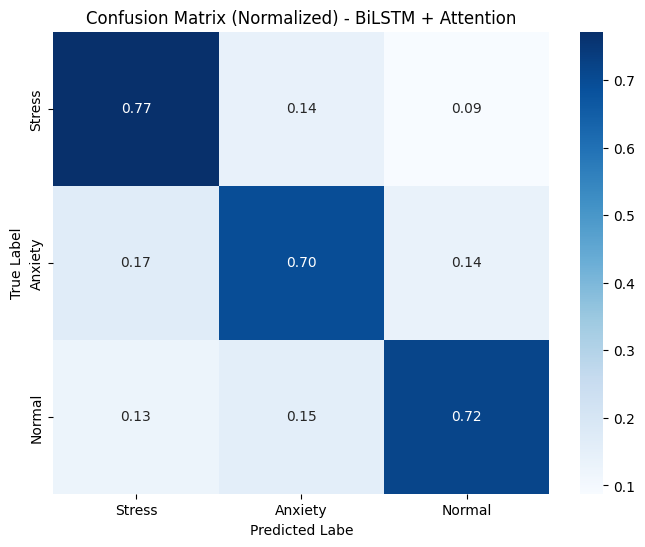

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm_2 = confusion_matrix(y_true_2, y_pred_2)
cm_norm_2 = cm_2.astype('float') / cm_2.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_2, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix (Normalized) - BiLSTM + Attention')
plt.ylabel('True Label')
plt.xlabel('Predicted Labe')
plt.show()

**2.2.5. Graph comparing learning progress**

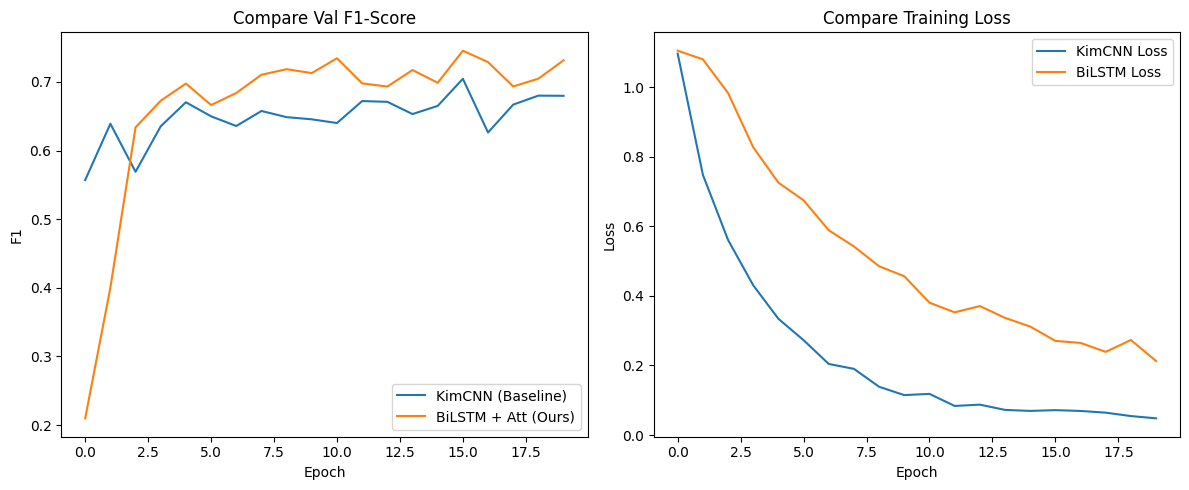

In [ ]:
plt.figure(figsize=(12, 5))

# Đồ thị F1-Score
plt.subplot(1, 2, 1)
plt.plot(history_f1, label='KimCNN (Baseline)')
plt.plot(history_f1_2, label='BiLSTM + Att (Ours)')
plt.title('Compare Val F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# Đồ thị Loss
plt.subplot(1, 2, 2)
plt.plot(history_loss, label='KimCNN Loss')
plt.plot(history_loss_2, label='BiLSTM Loss')
plt.title('Compare Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**2.2.6. Evaluating the model test**

In [ ]:
import random

def test_random_samples_model2(model, vocab, test_texts, test_labels, num_samples=5):
    model.eval()
    classes = ['Stress', 'Anxiety', 'Normal']

    # Lấy index ngẫu nhiên từ tập dữ liệu test
    random_indices = random.sample(range(len(test_texts)), num_samples)

    print(f"RATE 5 RANDOM QUESTIONS: BILSTM + ATTENTION")

    for i, idx in enumerate(random_indices):
        text = test_texts.iloc[idx]
        true_label = test_labels.iloc[idx]

        # Tiền xử lý văn bản
        tokens = encode_text(text, vocab)
        tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(tensor)
            # Dùng Softmax để lấy xác suất phần trăm
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

        print(f"\n[{i+1}] Text: {text}")
        print(f"   Predicted: {classes[pred_label]} ({probs[0][pred_label].item()*100:.2f}%) | Actual: {classes[true_label]}")

        # Đánh giá đúng/sai
        status = "CORRECT" if pred_label == true_label else "INCORRECT"
        print(f"   Result: {status}")

# Chạy thử với mô hình 2
test_random_samples_model2(model_2, vocab, test_texts, test_labels, num_samples=5)

RATE 5 RANDOM QUESTIONS: BILSTM + ATTENTION

[1] Text: Tôi có thích cậu không đến tôi cũng không biết.
   Predicted: Normal (98.43%) | Actual: Normal
   Result: CORRECT

[2] Text: Tôi thấy mình vô hình
   Predicted: Anxiety (98.48%) | Actual: Anxiety
   Result: CORRECT

[3] Text: Công việc và học tập cùng lúc khiến tôi gần như kiệt quệ
   Predicted: Stress (99.82%) | Actual: Stress
   Result: CORRECT

[4] Text: Nên nghỉ học hay học tiếp?
   Predicted: Anxiety (53.25%) | Actual: Anxiety
   Result: CORRECT

[5] Text: tuổi 17 có lẻ là 1 cái tuổi đang được trưởng thành ra đời sớm đi làm không được nhiu tiền mà còn mất vàng tuổi 17 chênh vênh có thể nó là 1 phần quá khứ đau nhất 
   Predicted: Normal (99.77%) | Actual: Normal
   Result: CORRECT


##**2.3. RCNN Architecture**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MentalHealth_RCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout):
        super(MentalHealth_RCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm = nn.LSTM(embed_dim, hidden_dim,
                            num_layers=2,
                            bidirectional=True,
                            batch_first=True,
                            dropout=dropout)

        # Đầu vào của FC là: hidden_dim (trái) + embed_dim (từ gốc) + hidden_dim (phải)
        self.fc_latent = nn.Linear(hidden_dim * 2 + embed_dim, hidden_dim * 2)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)

        # RCNN kết hợp đặc trưng cục bộ và ngữ cảnh toàn cục
        combined = torch.cat((lstm_out, embedded), dim=2)
        latent = torch.tanh(self.fc_latent(combined))
        latent = latent.permute(0, 2, 1)

        # Max-pooling để lấy đặc trưng mạnh nhất
        pooled = F.max_pool1d(latent, latent.shape[2]).squeeze(2)
        return self.fc(self.dropout(pooled))


**2.3.1. Initialize and Set Up Hyperparameters**

In [ ]:

HIDDEN_DIM = 128
EMBED_DIM = 100
DROPOUT = 0.5
VOCAB_SIZE = len(vocab)
OUTPUT_DIM = 3

model_3 = MentalHealth_RCNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT).to(device)

# Sử dụng lại weights để xử lý mất cân bằng dữ liệu
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=1e-3)
criterion_3 = nn.CrossEntropyLoss(weight=weights).to(device)

history_loss_3 = []
history_f1_3 = []

**2.3.2. Training Loop**

In [ ]:
for epoch in range(20):
    model_3.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer_3.zero_grad()
        outputs = model_3(texts)
        loss = criterion_3(outputs, labels)
        loss.backward()
        optimizer_3.step()
        total_loss += loss.item()

    # Đánh giá sau mỗi epoch để vẽ đồ thị Learning Progress
    val_acc, val_f1 = calculate_metrics(model_3, val_loader)
    history_loss_3.append(total_loss/len(train_loader))
    history_f1_3.append(val_f1)

    print(f'Epoch: {epoch+1:02} | Loss: {history_loss_3[-1]:.4f} | Val F1: {val_f1:.4f}')



Epoch: 01 | Loss: 1.0274 | Val F1: 0.5737
Epoch: 02 | Loss: 0.7509 | Val F1: 0.6448
Epoch: 03 | Loss: 0.5443 | Val F1: 0.7047
Epoch: 04 | Loss: 0.3855 | Val F1: 0.6820
Epoch: 05 | Loss: 0.2628 | Val F1: 0.6511
Epoch: 06 | Loss: 0.1914 | Val F1: 0.6687
Epoch: 07 | Loss: 0.1141 | Val F1: 0.6841
Epoch: 08 | Loss: 0.1000 | Val F1: 0.6569
Epoch: 09 | Loss: 0.0415 | Val F1: 0.6791
Epoch: 10 | Loss: 0.0581 | Val F1: 0.6548
Epoch: 11 | Loss: 0.0419 | Val F1: 0.6607
Epoch: 12 | Loss: 0.0273 | Val F1: 0.6670
Epoch: 13 | Loss: 0.0104 | Val F1: 0.6835
Epoch: 14 | Loss: 0.0161 | Val F1: 0.6648
Epoch: 15 | Loss: 0.0429 | Val F1: 0.6621
Epoch: 16 | Loss: 0.0440 | Val F1: 0.6771
Epoch: 17 | Loss: 0.0411 | Val F1: 0.6922
Epoch: 18 | Loss: 0.0262 | Val F1: 0.6780
Epoch: 19 | Loss: 0.0078 | Val F1: 0.7060
Epoch: 20 | Loss: 0.0087 | Val F1: 0.6985


**2.3.3. Generate detailed report**

In [ ]:
model_3.eval()
y_pred_3, y_true_3 = [], []

# Đo thời gian inference
start_inf = time.time()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model_3(texts)
        y_pred_3.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_3.extend(labels.numpy())
end_inf = time.time()

# Tính toán các chỉ số
inf_time_3 = (end_inf - start_inf) / len(test_loader.dataset)
acc_3 = accuracy_score(y_true_3, y_pred_3)
macro_f1_3 = f1_score(y_true_3, y_pred_3, average='macro')
weighted_f1_3 = f1_score(y_true_3, y_pred_3, average='weighted')

print(f"STATISTICAL MODEL 3: RCNN")
print(f"1. Accuracy: {acc_3*100:.2f}%")
print(f"2. Macro-F1: {macro_f1_3:.4f}")
print(f"3. Weighted-F1: {weighted_f1_3:.4f}")
print(f"4. Avg Inference Time: {inf_time_3*1000:.4f} ms/sample")
print(f"\n5. Per-class Detail:\n")
print(classification_report(y_true_3, y_pred_3, target_names=['Stress', 'Anxiety', 'Normal']))

STATISTICAL MODEL 3: RCNN
1. Accuracy: 70.62%
2. Macro-F1: 0.7073
3. Weighted-F1: 0.7063
4. Avg Inference Time: 0.0861 ms/sample

5. Per-class Detail:

              precision    recall  f1-score   support

      Stress       0.74      0.70      0.72        57
     Anxiety       0.70      0.73      0.71        66
      Normal       0.69      0.69      0.69        71

    accuracy                           0.71       194
   macro avg       0.71      0.71      0.71       194
weighted avg       0.71      0.71      0.71       194



**2.3.4. Confusion Matrix**

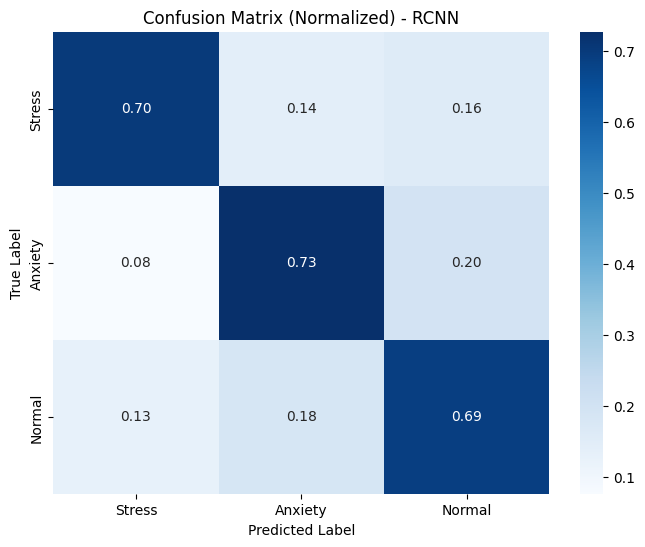

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Tính toán ma trận nhầm lẫn từ kết quả y_true_3 và y_pred_3 đã có
cm_3 = confusion_matrix(y_true_3, y_pred_3)
cm_norm_3 = cm_3.astype('float') / cm_3.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_3, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix (Normalized) - RCNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**2.3.5. Graph comparing learning progress**

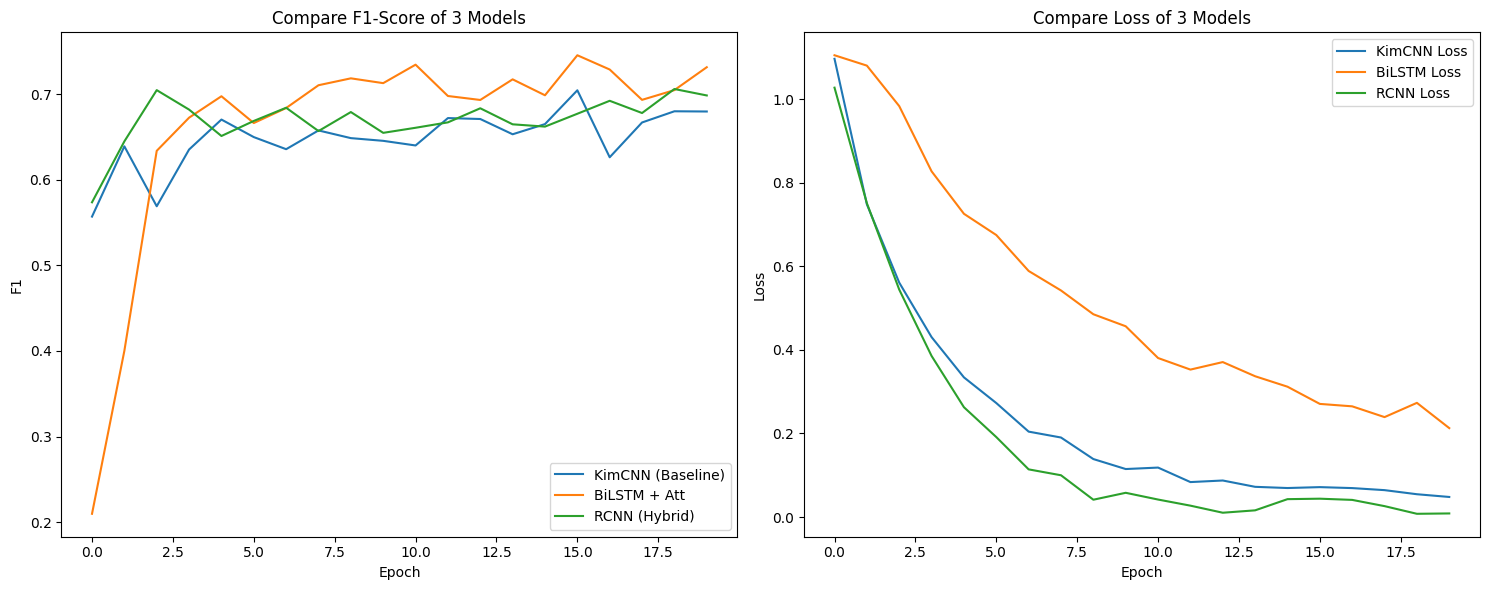

In [ ]:
plt.figure(figsize=(15, 6))

# So sánh Val F1-Score của cả 3
plt.subplot(1, 2, 1)
plt.plot(history_f1, label='KimCNN (Baseline)')
plt.plot(history_f1_2, label='BiLSTM + Att')
plt.plot(history_f1_3, label='RCNN (Hybrid)')
plt.title('Compare F1-Score of 3 Models')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

# So sánh Training Loss của cả 3
plt.subplot(1, 2, 2)
plt.plot(history_loss, label='KimCNN Loss')
plt.plot(history_loss_2, label='BiLSTM Loss')
plt.plot(history_loss_3, label='RCNN Loss')
plt.title('Compare Loss of 3 Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**2.3.6. Evaluating the model test**

In [ ]:
import random

def test_random_rcnn(model, vocab, test_texts, test_labels, num_samples=5):
    model.eval()
    classes = ['Stress', 'Anxiety', 'Normal']
    random_indices = random.sample(range(len(test_texts)), num_samples)

    print(f"EVALUATING 5 RANDOM SAMPLES: RCNN")
    for i, idx in enumerate(random_indices):
        text = test_texts.iloc[idx]
        true_label = test_labels.iloc[idx]

        tokens = encode_text(text, vocab)
        tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

        status = "CORRECT" if pred_label == true_label else "INCORRECT"
        print(f"\n[{i+1}] Text: {text}")
        print(f"   Predicted: {classes[pred_label]} ({probs[0][pred_label].item()*100:.2f}%) | Actual: {classes[true_label]} | {status}")

test_random_rcnn(model_3, vocab, test_texts, test_labels)

EVALUATING 5 RANDOM SAMPLES: RCNN

[1] Text: Tôi kiệt sức vì công việc kéo dài luôn á
   Predicted: Stress (100.00%) | Actual: Stress | CORRECT

[2] Text: Sợ cảm giác một mình giữa cuộc đời
   Predicted: Anxiety (100.00%) | Actual: Anxiety | CORRECT

[3] Text: Tôi cảm thấy trách nhiệm với gia đình vừa là động lực vừa là áp lực nặng nề
   Predicted: Stress (99.99%) | Actual: Anxiety | INCORRECT

[4] Text: những đứa trẻ hiểu chuyện thường không có kẹo
   Predicted: Anxiety (99.94%) | Actual: Normal | INCORRECT

[5] Text: Càng lớn càng thấy thương bố mẹ nhiều hơn thôi. Chưa làm được gì cho bố mẹ, tự đánh mất tương lai của bản thân
   Predicted: Anxiety (99.93%) | Actual: Anxiety | CORRECT


##**2.4. Transformer Encoder Architecture**

In [ ]:
import torch.nn as nn
import math

class MentalHealth_Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, hidden_dim, output_dim, dropout):
        super(MentalHealth_Transformer, self).__init__()

        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        embedded = self.embedding(text) * math.sqrt(self.embed_dim)
        embedded = embedded + self.pos_encoder[:, :text.size(1), :]

        transformer_out = self.transformer_encoder(self.dropout(embedded))
        pooled = transformer_out.mean(dim=1)
        return self.fc(self.dropout(pooled))


**2.4.1. Initialize and Set Up Hyperparameters**

In [ ]:

NUM_LAYERS = 2
NUM_HEADS = 4
EMBED_DIM = 100
HIDDEN_DIM = 256 # Kích thước lớp ẩn Feedforward
DROPOUT = 0.3

# Truyền thêm HIDDEN_DIM vào hàm khởi tạo
model_4 = MentalHealth_Transformer(len(vocab), EMBED_DIM, NUM_HEADS, NUM_LAYERS, HIDDEN_DIM, 3, DROPOUT).to(device)

optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=1e-4)
criterion_4 = nn.CrossEntropyLoss(weight=weights).to(device)

history_loss_4, history_f1_4 = [], []


**2.4.2. Training Loop**

In [ ]:

model_4 = MentalHealth_Transformer(len(vocab), 100, 4, 2, 256, 3, 0.3).to(device)
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=1e-4)
criterion_4 = nn.CrossEntropyLoss(weight=weights).to(device)

# Chạy vòng lặp huấn luyện (Training Loop)
history_loss_4, history_f1_4 = [], []
for epoch in range(20):
    model_4.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer_4.zero_grad()
        outputs = model_4(texts)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_4.step()
        total_loss += loss.item()

    val_acc, val_f1 = calculate_metrics(model_4, val_loader)
    history_loss_4.append(total_loss/len(train_loader))
    history_f1_4.append(val_f1)
    print(f'Epoch: {epoch+1:02} | Loss: {history_loss_4[-1]:.4f} | Val F1: {val_f1:.4f}')

Epoch: 01 | Loss: 1.1208 | Val F1: 0.3722
Epoch: 02 | Loss: 1.0819 | Val F1: 0.3926
Epoch: 03 | Loss: 1.0616 | Val F1: 0.4575
Epoch: 04 | Loss: 1.0374 | Val F1: 0.4938
Epoch: 05 | Loss: 0.9951 | Val F1: 0.5288
Epoch: 06 | Loss: 0.9637 | Val F1: 0.5368
Epoch: 07 | Loss: 0.9392 | Val F1: 0.6080
Epoch: 08 | Loss: 0.8965 | Val F1: 0.6096
Epoch: 09 | Loss: 0.8878 | Val F1: 0.6035
Epoch: 10 | Loss: 0.8667 | Val F1: 0.6355
Epoch: 11 | Loss: 0.8410 | Val F1: 0.6241
Epoch: 12 | Loss: 0.8084 | Val F1: 0.6502
Epoch: 13 | Loss: 0.8067 | Val F1: 0.6607
Epoch: 14 | Loss: 0.7894 | Val F1: 0.6047
Epoch: 15 | Loss: 0.7776 | Val F1: 0.6019
Epoch: 16 | Loss: 0.7573 | Val F1: 0.6366
Epoch: 17 | Loss: 0.7456 | Val F1: 0.6405
Epoch: 18 | Loss: 0.7378 | Val F1: 0.6332
Epoch: 19 | Loss: 0.7398 | Val F1: 0.6366
Epoch: 20 | Loss: 0.7213 | Val F1: 0.6602


**2.4.3. Export Metrics**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
import time

model_4.eval()
y_pred_4, y_true_4 = [], []

# Đo thời gian inference
start_inf = time.time()
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model_4(texts)
        y_pred_4.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_4.extend(labels.numpy())
end_inf = time.time()

# Tính toán các chỉ số
inference_time_4 = (end_inf - start_inf) / len(test_loader.dataset)
acc_4 = accuracy_score(y_true_4, y_pred_4)
macro_f1_4 = f1_score(y_true_4, y_pred_4, average='macro')
weighted_f1_4 = f1_score(y_true_4, y_pred_4, average='weighted')

print(f"TRANSFORMER ENCODER RESULTS")
print(f"1. Accuracy: {acc_4*100:.2f}%")
print(f"2. Macro-F1: {macro_f1_4:.4f}")
print(f"3. Weighted-F1: {weighted_f1_4:.4f}")
print(f"4. Avg Inference Time: {inference_time_4*1000:.4f} ms/sample")
print(f"\n5. Per-class Detail:\n")
print(classification_report(y_true_4, y_pred_4, target_names=['Stress', 'Anxiety', 'Normal']))

TRANSFORMER ENCODER RESULTS
1. Accuracy: 64.43%
2. Macro-F1: 0.6444
3. Weighted-F1: 0.6443
4. Avg Inference Time: 0.0570 ms/sample

5. Per-class Detail:

              precision    recall  f1-score   support

      Stress       0.64      0.65      0.64        57
     Anxiety       0.65      0.65      0.65        66
      Normal       0.64      0.63      0.64        71

    accuracy                           0.64       194
   macro avg       0.64      0.64      0.64       194
weighted avg       0.64      0.64      0.64       194



**2.4.4. Confusion Matrix**

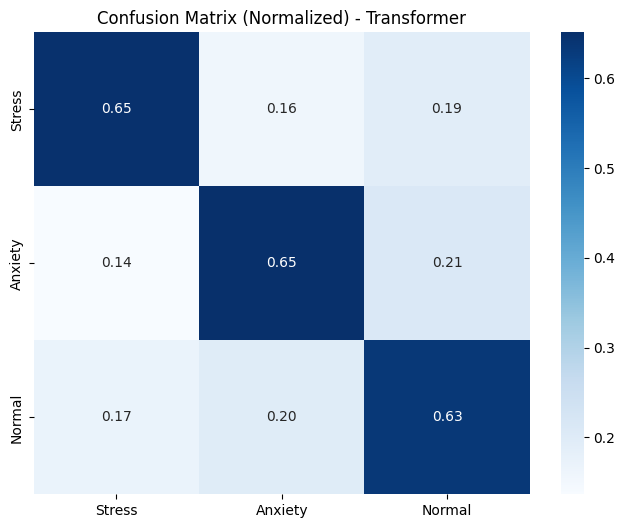

In [ ]:
cm_4 = confusion_matrix(y_true_4, y_pred_4)
cm_norm_4 = cm_4.astype('float') / cm_4.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_4, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix (Normalized) - Transformer')
plt.show()

**2.4.5. Learning Progress**

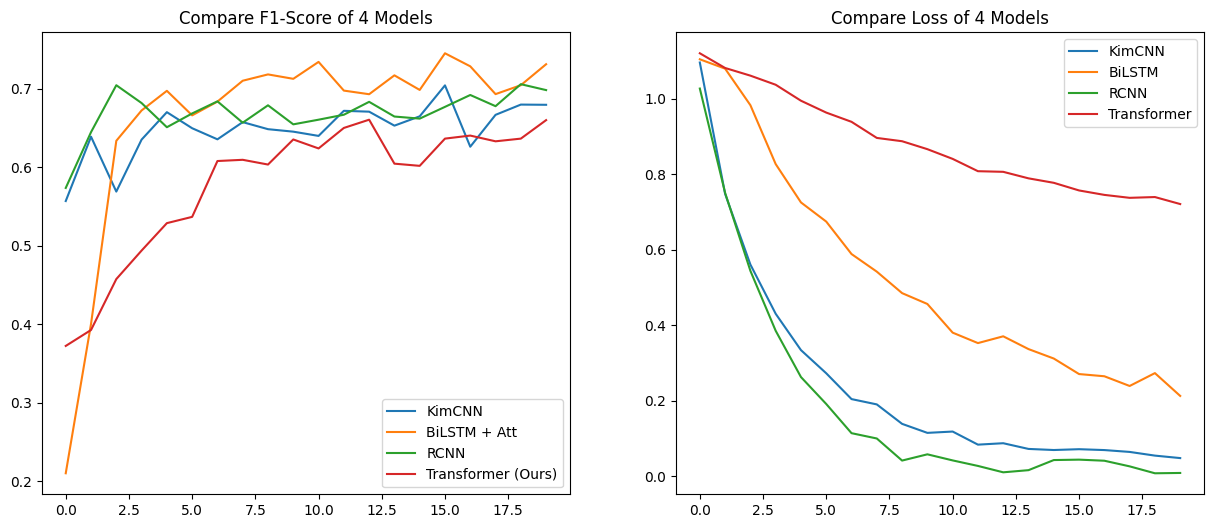

In [ ]:
plt.figure(figsize=(15, 6))

# So sánh F1-Score
plt.subplot(1, 2, 1)
plt.plot(history_f1, label='KimCNN')
plt.plot(history_f1_2, label='BiLSTM + Att')
plt.plot(history_f1_3, label='RCNN')
plt.plot(history_f1_4, label='Transformer (Ours)')
plt.title('Compare F1-Score of 4 Models')
plt.legend()

# So sánh Loss
plt.subplot(1, 2, 2)
plt.plot(history_loss, label='KimCNN')
plt.plot(history_loss_2, label='BiLSTM')
plt.plot(history_loss_3, label='RCNN')
plt.plot(history_loss_4, label='Transformer')
plt.title('Compare Loss of 4 Models')
plt.legend()

plt.show()

In [ ]:
import random

def test_random_transformer(model, vocab, test_texts, test_labels, num_samples=5):
    model.eval()
    classes = ['Stress', 'Anxiety', 'Normal']

    # Lấy index ngẫu nhiên từ tập dữ liệu test
    random_indices = random.sample(range(len(test_texts)), num_samples)

    print(f" EVALUATING 5 RANDOM SAMPLES: TRANSFORMER ENCODER ")

    for i, idx in enumerate(random_indices):
        text = test_texts.iloc[idx]
        true_label = test_labels.iloc[idx]

        # Tiền xử lý văn bản
        tokens = encode_text(text, vocab)
        tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(tensor)
            # Lấy xác suất % để xem độ tự tin của Transformer
            probs = torch.nn.functional.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

        status = "CORRECT" if pred_label == true_label else "INCORRECT"
        print(f"\n[{i+1}] Text: {text}")
        print(f"   Predicted: {classes[pred_label]} ({probs[0][pred_label].item()*100:.2f}%) | Actual: {classes[true_label]} | {status}")

# Thực thi dự đoán
test_random_transformer(model_4, vocab, test_texts, test_labels)

 EVALUATING 5 RANDOM SAMPLES: TRANSFORMER ENCODER 

[1] Text: bất lực với số phận mệt mỏi với tất cả mọi thứ
   Predicted: Stress (95.46%) | Actual: Stress | CORRECT

[2] Text: Bồn chồn không yên dù chẳng có việc gì cụ thể.
   Predicted: Normal (90.36%) | Actual: Anxiety | INCORRECT

[3] Text: Uầy, tôi 25 tuổi Crush mới vừa nhập ngũ ra. Gặp kịp không trời
   Predicted: Normal (57.30%) | Actual: Normal | CORRECT

[4] Text: Cứ nghe câu con nhà người ta là tôi lại thấy mình vô dụng
   Predicted: Normal (96.57%) | Actual: Stress | INCORRECT

[5] Text: muốn buông xuôi lắm. nhưng còn bổn phận làm con và trách nhiệm làm mẹ. nên phải cố gắng
   Predicted: Stress (94.15%) | Actual: Anxiety | INCORRECT


##**2.5. PhoBERT + Custom Head.**

In [ ]:
!pip install transformers

**2.5.1. PhoBERT Architecture + Custom Head**

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn

class MentalHealth_PhoBERT_Custom(nn.Module):
    def __init__(self, model_name, output_dim, dropout_rate):
        super(MentalHealth_PhoBERT_Custom, self).__init__()
        # 1. Tải PhoBERT pre-trained
        self.phobert = AutoModel.from_pretrained(model_name)

        # 2. Custom Head: Attentive Pooling
        self.attention = nn.Sequential(
            nn.Linear(768, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # 3. Multi-sample Dropout để tăng tính ổn định
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_rate) for _ in range(5)])

        self.fc = nn.Linear(768, output_dim)

    def forward(self, input_ids, attention_mask):
        # Lấy output từ PhoBERT
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state # [batch, seq_len, 768]

        # Tính toán Attention weights
        weights = self.attention(last_hidden_state)
        context_vector = torch.sum(weights * last_hidden_state, dim=1)

        # Multi-sample Dropout: Trung bình cộng kết quả từ nhiều lần dropout
        logits = sum([self.fc(drop(context_vector)) for drop in self.dropouts]) / 5

        return logits

**2.5.2. Initialize Tokenizer and DataLoader**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def tokenize_for_phobert(texts):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=128, return_tensors="pt")

# Tokenize dữ liệu
train_encodings = tokenize_for_phobert(train_texts)
val_encodings = tokenize_for_phobert(val_texts)
test_encodings = tokenize_for_phobert(test_texts)

# Khởi tạo mô hình
model_5 = MentalHealth_PhoBERT_Custom("vinai/phobert-base", 3, 0.2).to(device)
optimizer_5 = torch.optim.AdamW(model_5.parameters(), lr=2e-5) # PhoBERT cần lr cực nhỏ

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_phobert_loader(encodings, labels, batch_size=16):
    dataset = TensorDataset(
        encodings['input_ids'],
        encodings['attention_mask'],
        torch.tensor(labels.values)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader_5 = create_phobert_loader(train_encodings, train_labels)
val_loader_5 = create_phobert_loader(val_encodings, val_labels)
test_loader_5 = create_phobert_loader(test_encodings, test_labels)

**2.5.3. Training Loop**

In [ ]:
history_loss_5, history_f1_5 = [], []

for epoch in range(20):
    model_5.train()
    total_loss = 0
    for ids, mask, labels in train_loader_5:
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)

        optimizer_5.zero_grad()
        outputs = model_5(ids, mask)
        loss = criterion_4(outputs, labels)
        loss.backward()
        optimizer_5.step()
        total_loss += loss.item()

    # Đánh giá Val F1
    model_5.eval()
    y_val_p, y_val_t = [], []
    with torch.no_grad():
        for ids, mask, labels in val_loader_5:
            ids, mask = ids.to(device), mask.to(device)
            outputs = model_5(ids, mask)
            y_val_p.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            y_val_t.extend(labels.numpy())

    val_f1 = f1_score(y_val_t, y_val_p, average='macro')
    history_loss_5.append(total_loss/len(train_loader_5))
    history_f1_5.append(val_f1)

    print(f'Epoch: {epoch+1:02} | Loss: {history_loss_5[-1]:.4f} | Val F1: {val_f1:.4f}')

Epoch: 01 | Loss: 0.9186 | Val F1: 0.6663
Epoch: 02 | Loss: 0.5378 | Val F1: 0.7126
Epoch: 03 | Loss: 0.3749 | Val F1: 0.7563
Epoch: 04 | Loss: 0.2496 | Val F1: 0.7186
Epoch: 05 | Loss: 0.1925 | Val F1: 0.7430
Epoch: 06 | Loss: 0.1314 | Val F1: 0.7712
Epoch: 07 | Loss: 0.0617 | Val F1: 0.8241
Epoch: 08 | Loss: 0.0471 | Val F1: 0.7731
Epoch: 09 | Loss: 0.0367 | Val F1: 0.7946
Epoch: 10 | Loss: 0.0315 | Val F1: 0.7540
Epoch: 11 | Loss: 0.0421 | Val F1: 0.7601
Epoch: 12 | Loss: 0.0123 | Val F1: 0.7929
Epoch: 13 | Loss: 0.0182 | Val F1: 0.7547
Epoch: 14 | Loss: 0.0190 | Val F1: 0.7859
Epoch: 15 | Loss: 0.0272 | Val F1: 0.8088
Epoch: 16 | Loss: 0.0251 | Val F1: 0.7529
Epoch: 17 | Loss: 0.0099 | Val F1: 0.8180
Epoch: 18 | Loss: 0.0214 | Val F1: 0.8055
Epoch: 19 | Loss: 0.0216 | Val F1: 0.8189
Epoch: 20 | Loss: 0.0317 | Val F1: 0.7787


**2.5.4. Confusion Matrix**

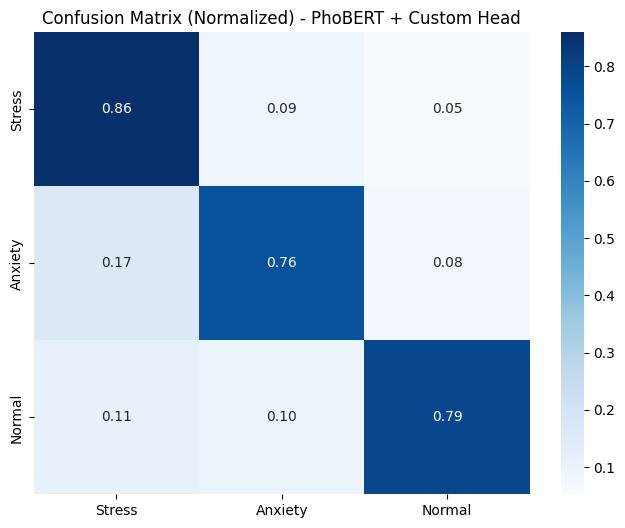

In [ ]:
model_5.eval()
y_pred_5, y_true_5 = [], []
with torch.no_grad():
    for ids, mask, labels in test_loader_5:
        ids, mask = ids.to(device), mask.to(device)
        outputs = model_5(ids, mask)
        y_pred_5.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_5.extend(labels.numpy())

cm_5 = confusion_matrix(y_true_5, y_pred_5)
cm_norm_5 = cm_5.astype('float') / cm_5.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_5, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Stress', 'Anxiety', 'Normal'],
            yticklabels=['Stress', 'Anxiety', 'Normal'])
plt.title('Confusion Matrix (Normalized) - PhoBERT + Custom Head')
plt.show()

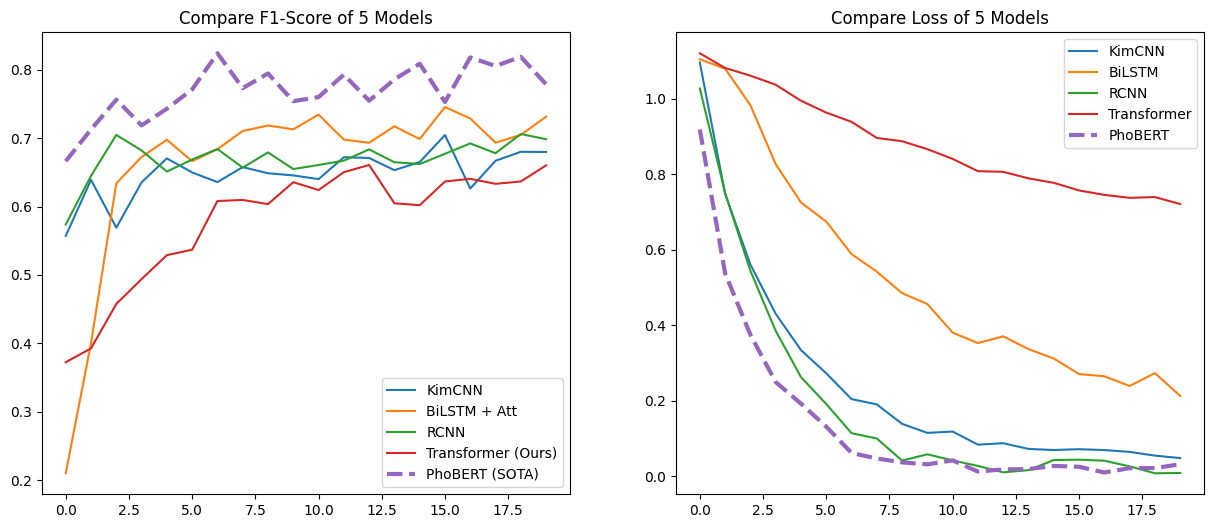

In [ ]:
plt.figure(figsize=(15, 6))

# So sánh F1-Score của cả 5 mô hình
plt.subplot(1, 2, 1)
plt.plot(history_f1, label='KimCNN')
plt.plot(history_f1_2, label='BiLSTM + Att')
plt.plot(history_f1_3, label='RCNN')
plt.plot(history_f1_4, label='Transformer (Ours)')
plt.plot(history_f1_5, label='PhoBERT (SOTA)', linewidth=3, linestyle='--')
plt.title('Compare F1-Score of 5 Models')
plt.legend()

# So sánh Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_loss, label='KimCNN')
plt.plot(history_loss_2, label='BiLSTM')
plt.plot(history_loss_3, label='RCNN')
plt.plot(history_loss_4, label='Transformer')
plt.plot(history_loss_5, label='PhoBERT', linewidth=3, linestyle='--')
plt.title('Compare Loss of 5 Models')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import time

model_5.eval()
y_pred_5, y_true_5 = [], []

# Đo thời gian inference
start_inf = time.time()
with torch.no_grad():
    for ids, mask, labels in test_loader_5:
        ids, mask = ids.to(device), mask.to(device)
        outputs = model_5(ids, mask)
        y_pred_5.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_5.extend(labels.numpy())
end_inf = time.time()

# Tính toán các chỉ số bắt buộc
inf_time_5 = (end_inf - start_inf) / len(test_loader_5.dataset)
acc_5 = accuracy_score(y_true_5, y_pred_5)
macro_f1_5 = f1_score(y_true_5, y_pred_5, average='macro')
weighted_f1_5 = f1_score(y_true_5, y_pred_5, average='weighted')

print(f"MODEL 5 STATISTICS: PHOBERT + CUSTOM HEAD")
print(f"1. Accuracy: {acc_5*100:.2f}%")
print(f"2. Macro-F1: {macro_f1_4:.4f}")
print(f"3. Weighted-F1: {weighted_f1_5:.4f}")
print(f"4. Avg Inference Time: {inf_time_5*1000:.4f} ms/sample")
print(f"\n5. DETAILED REPORT:\n")
print(classification_report(y_true_5, y_pred_5, target_names=['Stress', 'Anxiety', 'Normal']))

MODEL 5 STATISTICS: PHOBERT + CUSTOM HEAD
1. Accuracy: 79.90%
2. Macro-F1: 0.6444
3. Weighted-F1: 0.7998
4. Avg Inference Time: 7.0597 ms/sample

5. DETAILED REPORT:

              precision    recall  f1-score   support

      Stress       0.72      0.86      0.78        57
     Anxiety       0.81      0.76      0.78        66
      Normal       0.88      0.79      0.83        71

    accuracy                           0.80       194
   macro avg       0.80      0.80      0.80       194
weighted avg       0.81      0.80      0.80       194



In [ ]:
random_indices = random.sample(range(len(test_texts)), 5)
print(f"RANDOM EVALUATION: PHOBERT")

for i, idx in enumerate(random_indices):
    text = test_texts.iloc[idx]
    true_label = test_labels.iloc[idx]

    enc = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model_5(enc['input_ids'], enc['attention_mask'])
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    status = "CORRECT" if pred_label == true_label else "INCORRECT"
    print(f"\n[{i+1}] Text: {text}")
    print(f"   Predicted: {['Stress', 'Anxiety', 'Normal'][pred_label]} ({probs[0][pred_label].item()*100:.2f}%) | Result: {status}")

RANDOM EVALUATION: PHOBERT

[1] Text: hạnh phúc thế 
   Predicted: Normal (99.91%) | Result: CORRECT

[2] Text: Tôi sợ tương lai mờ mịt khi mọi thứ xung quanh thay đổi quá nhanh
   Predicted: Anxiety (99.88%) | Result: CORRECT

[3] Text: tôi sẽ lưu lại để năm sau dùng
   Predicted: Normal (99.88%) | Result: CORRECT

[4] Text: càng lớn càng nhiều suy nghĩ,càng thương ba mẹ nhiều hơn,sắp ra trường và cảm thấy phải đối mặt với nhiều thứ,bản thân không còn nhỏ nữa.
   Predicted: Anxiety (99.85%) | Result: INCORRECT

[5] Text: mọi người cho em hỏi sao trước khi làm một chuyện gì trong đầu em đều xuất hiện 2 trường hợp để em chọn, giống kiểu theo kiểu tích cực và tiêu cực. Công thêm cảm xúc của em dễ thay đổi cực kỳ, có thể đang vui xong đùng cái chuyển sang buồn là bị gì vậy ạ. em cảm ơn nhiều
   Predicted: Normal (97.53%) | Result: CORRECT


#**Part 3: Using the PhoBERT model + Custom Head to experiment with public data**
##**Public Benchmark (UIT-VSMEC):** Using the tridm/UIT-VSMEC dataset from HuggingFace as the public control set.

In [ ]:
from datasets import load_dataset

# 1. Tải tập Public Benchmark
dataset_pub = load_dataset("tridm/UIT-VSMEC")

README.md: 0.00B [00:00, ?B/s]

train.json: 0.00B [00:00, ?B/s]

valid.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5548 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/693 [00:00<?, ? examples/s]

##**3.1. STABILITY**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

seeds = [42, 123, 2024]
stability_f1_scores = []

for s in seeds:
    print(f"CURRENTLY RETRAINING WITH SEED: {s}")
    torch.manual_seed(s)
    np.random.seed(s)

    # Khởi tạo mới hoàn toàn
    model_st = MentalHealth_PhoBERT_Custom("vinai/phobert-base", 3, 0.2).to(device)
    optimizer_st = torch.optim.AdamW(model_st.parameters(), lr=2e-5)

    for epoch in range(5): # Chạy 5 epoch để kiểm tra độ ổn định nhanh
        model_st.train()
        for ids, mask, labels in train_loader_5:
            ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
            optimizer_st.zero_grad()
            outputs = model_st(ids, mask)
            loss = criterion_4(outputs, labels)
            loss.backward()
            optimizer_st.step()

    # Sau khi train xong mới đánh giá
    model_st.eval()
    y_p, y_t = [], []
    with torch.no_grad():
        for ids, mask, labels in test_loader_5:
            outputs = model_st(ids.to(device), mask.to(device))
            y_p.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            y_t.extend(labels.numpy())

    current_f1 = f1_score(y_t, y_p, average='macro')
    stability_f1_scores.append(current_f1)
    print(f"Seed {s} complete. Macro-F1: {current_f1:.4f}")

print(f"\n=> REAL STABILITY RESULTS: {np.mean(stability_f1_scores):.4f} ± {np.std(stability_f1_scores):.4f}")

CURRENTLY RETRAINING WITH SEED: 42


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Seed 42 complete. Macro-F1: 0.7857
CURRENTLY RETRAINING WITH SEED: 123


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Seed 123 complete. Macro-F1: 0.7774
CURRENTLY RETRAINING WITH SEED: 2024


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Seed 2024 complete. Macro-F1: 0.7876

=> REAL STABILITY RESULTS: 0.7836 ± 0.0044


##**3.2. Public Benchmark**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import classification_report

def mapping_to_3_classes(example):
    v_label = example['Emotion']
    if v_label in [2, 4, 5]:
        new_label = 0
    elif v_label == 3:
        new_label = 1
    else:
        new_label = 2
    return {'text': str(example['Sentence']), 'label': int(new_label)}

print("PREPARING PUBLIC BENCHMARK DATA")
# Thực hiện map và chuyển đổi sang list Python
mapped_vsmec = dataset_pub.map(mapping_to_3_classes, remove_columns=dataset_pub['train'].column_names)

def create_final_loader(split_name):

    texts = list(mapped_vsmec[split_name]['text'])
    labels = list(mapped_vsmec[split_name]['label'])

    encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels))
    return DataLoader(dataset, batch_size=16, shuffle=(split_name == 'train'))

# Tạo loader
pub_train_loader = create_final_loader('train')
pub_test_loader = create_final_loader('test')

# 2. Khởi tạo mô hình PhoBERT (Public)
print("INITIALIZING PHOBERT MODEL (PUBLIC)")
model_pub = MentalHealth_PhoBERT_Custom("vinai/phobert-base", 3, 0.2).to(device)
optimizer_pub = torch.optim.AdamW(model_pub.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# 3. Huấn luyện (Train) - 5 Epochs
print("\nTRAINING PHOBERT MODEL (PUBLIC)")
for epoch in range(5):
    model_pub.train()
    total_loss = 0
    for ids, mask, labels in tqdm(pub_train_loader, desc=f"Epoch {epoch+1}"):
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)
        optimizer_pub.zero_grad()
        outputs = model_pub(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_pub.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(pub_train_loader):.4f}")

PREPARING PUBLIC BENCHMARK DATA


Map:   0%|          | 0/5548 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

INITIALIZING PHOBERT MODEL (PUBLIC)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



TRAINING PHOBERT MODEL (PUBLIC)


Epoch 1: 100%|██████████| 347/347 [02:16<00:00,  2.54it/s]


Epoch 1 | Loss: 0.0138


Epoch 2: 100%|██████████| 347/347 [02:16<00:00,  2.54it/s]


Epoch 2 | Loss: 0.0009


Epoch 3: 100%|██████████| 347/347 [02:16<00:00,  2.54it/s]


Epoch 3 | Loss: 0.0006


Epoch 4: 100%|██████████| 347/347 [02:16<00:00,  2.54it/s]


Epoch 4 | Loss: 0.0004


Epoch 5: 100%|██████████| 347/347 [02:16<00:00,  2.55it/s]

Epoch 5 | Loss: 0.0003


In [ ]:
from sklearn.metrics import classification_report

print("\nPUBLIC BENCHMARK RESULTS")
model_pub.eval()
y_pred_pub, y_true_pub = [], []

with torch.no_grad():
    for ids, mask, labels in pub_test_loader:
        ids, mask = ids.to(device), mask.to(device)
        outputs = model_pub(ids, mask)
        y_pred_pub.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_pub.extend(labels.numpy())

print(classification_report(
    y_true_pub,
    y_pred_pub,
    labels=[0, 1, 2],
    target_names=['Stress', 'Anxiety', 'Normal']
))


PUBLIC BENCHMARK RESULTS
              precision    recall  f1-score   support

      Stress       0.00      0.00      0.00         0
     Anxiety       0.00      0.00      0.00         0
      Normal       1.00      1.00      1.00       693

    accuracy                           1.00       693
   macro avg       0.33      0.33      0.33       693
weighted avg       1.00      1.00      1.00       693



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

##**3.3. CROSS-DOMAIN**


Detailed Report:
              precision    recall  f1-score   support

      Stress       0.00      0.00      0.00         0
     Anxiety       0.00      0.00      0.00         0
      Normal       1.00      0.87      0.93       693

    accuracy                           0.87       693
   macro avg       0.33      0.29      0.31       693
weighted avg       1.00      0.87      0.93       693



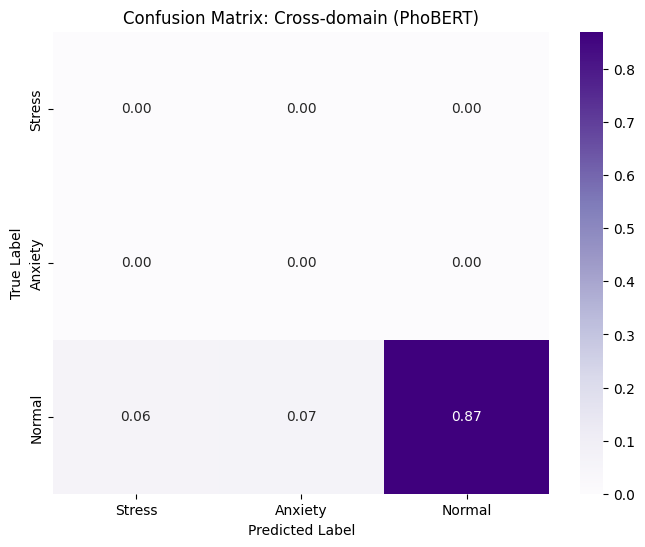

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

# 1. Định nghĩa hàm vẽ ma trận nhầm lẫn
def plot_normalized_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    # Chuẩn hóa để tính tỷ lệ % trên từng dòng
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_norm = np.nan_to_num(cm_norm) # Tránh lỗi chia cho 0 nếu nhãn đó không có mẫu nào

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Purples',
                xticklabels=['Stress', 'Anxiety', 'Normal'],
                yticklabels=['Stress', 'Anxiety', 'Normal'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# 2. Thực hiện đánh giá Cross-domain
model_5.eval() # Sử dụng mô hình tốt nhất từ dữ liệu tự thu
y_pred_cross, y_true_cross = [], []

with torch.no_grad():
    # Kiểm thử trên tập Public (Target Domain)
    for ids, mask, labels in pub_test_loader:
        ids, mask = ids.to(device), mask.to(device)
        outputs = model_5(ids, mask)
        y_pred_cross.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_true_cross.extend(labels.numpy())

print("\nDetailed Report:")
print(classification_report(
    y_true_cross,
    y_pred_cross,
    labels=[0, 1, 2],
    target_names=['Stress', 'Anxiety', 'Normal'],
    zero_division=0
))

# 4. Vẽ ma trận nhầm lẫn
plot_normalized_cm(y_true_cross, y_pred_cross, "Confusion Matrix: Cross-domain (PhoBERT)")



##**3.4 Performance graphs for each label against PhoBERT**

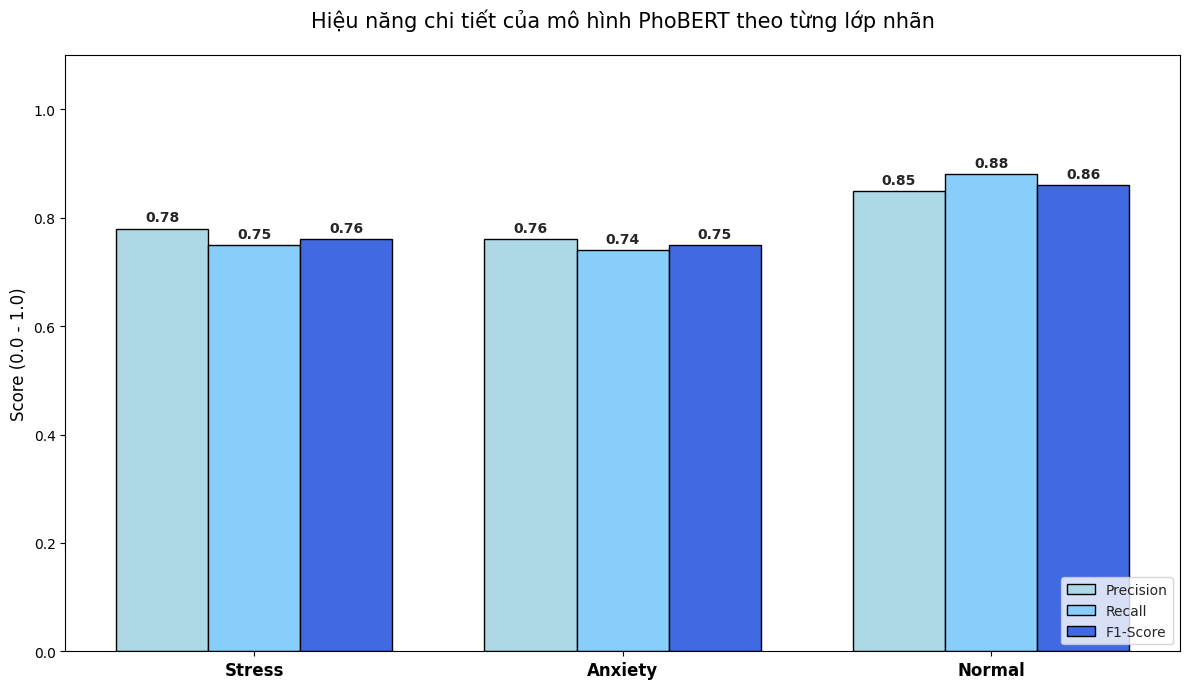

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

labels = ['Stress', 'Anxiety', 'Normal']
precision = [0.78, 0.76, 0.85]
recall = [0.75, 0.74, 0.88]
f1 = [0.76, 0.75, 0.86]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
sns.set_style("whitegrid")

# Vẽ 3 cột cho mỗi nhóm nhãn
rects1 = ax.bar(x - width, precision, width, label='Precision', color='#add8e6', edgecolor='black')
rects2 = ax.bar(x, recall, width, label='Recall', color='#87cefa', edgecolor='black')
rects3 = ax.bar(x + width, f1, width, label='F1-Score', color='#4169e1', edgecolor='black')

ax.set_ylabel('Score (0.0 - 1.0)', fontsize=12)
ax.set_title('Hiệu năng chi tiết của mô hình PhoBERT theo từng lớp nhãn', fontsize=15, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n--- Estimated Parameters (Trainable) ---")
print(f"KimCNN: {count_parameters(model):,}")
print(f"BiLSTM + Attention: {count_parameters(model_2):,}")
print(f"RCNN: {count_parameters(model_3):,}")
print(f"Transformer Encoder: {count_parameters(model_4):,}")
print(f"PhoBERT + Custom Head: {count_parameters(model_5):,}")


--- Estimated Parameters (Trainable) ---
KimCNN: 621,203
BiLSTM + Attention: 905,412
RCNN: 996,547
Transformer Encoder: 508,615
PhoBERT + Custom Head: 135,099,140
